# Import library & resources

## Install library

In [1]:
!pip install roboflow scikit-learn numpy pandas matplotlib opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


## Import library

In [7]:
from roboflow import Roboflow
import os
import cv2
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import files
import pickle

## Unduh datasheet

In [9]:
rf = Roboflow(api_key="WrMilUVQGzcdY3bTyCei")
project = rf.workspace("skripsi-aji").project("klasifikasi-sampah-organik-dan-anorganik")
version = project.version(35)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...


In [10]:
# Cek struktur folder dataset
base_path = dataset.location
print("Struktur dataset:")
print(os.listdir(base_path))

Struktur dataset:
['valid', 'test', 'README.dataset.txt', 'train', 'data.yaml', 'README.roboflow.txt']


In [11]:
# Path ke folder train, valid, dan test
train_path = os.path.join(base_path, 'train', 'images')
valid_path = os.path.join(base_path, 'valid', 'images')
test_path = os.path.join(base_path, 'test', 'images')

print(f"Train images: {len(os.listdir(train_path)) if os.path.exists(train_path) else 0}")
print(f"Valid images: {len(os.listdir(valid_path)) if os.path.exists(valid_path) else 0}")
print(f"Test images: {len(os.listdir(test_path)) if os.path.exists(test_path) else 0}")

Train images: 20391
Valid images: 473
Test images: 307


# Preprocessing datasheet

In [12]:
# Fungsi untuk preprocessing gambar
def preprocess_image(image_path, target_size=(64, 64)):
    img = cv2.imread(image_path)
    if img is None:  # Cek jika gambar gagal dibaca
        return None
    img = cv2.resize(img, target_size)  # Resize ke 64x64
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Ubah ke RGB
    img = img.flatten()  # Ubah ke vektor 1D
    return img

# Path ke folder train
train_images_path = os.path.join(base_path, 'train', 'images')
train_labels_path = os.path.join(base_path, 'train', 'labels')
valid_images_path = os.path.join(base_path, 'valid', 'images')
valid_labels_path = os.path.join(base_path, 'valid', 'labels')

# Membaca data dan label
X = []  # Data gambar
y = []  # Label (0: anorganik, 1: organik)

# Fungsi untuk membaca label dari file anotasi
def get_label_from_annotation(label_file_path):
    with open(label_file_path, 'r') as f:
        lines = f.readlines()
        if lines:  # Ambil label dari baris pertama
            class_id = int(lines[0].split()[0])  # Class ID ada di kolom pertama
            return class_id  # 0 untuk anorganik, 1 untuk organik
    return None

# Proses folder train
for img_file in os.listdir(train_images_path):
    if img_file.endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(train_images_path, img_file)
        label_file = os.path.join(train_labels_path, img_file.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt'))

        if os.path.exists(label_file):  # Pastikan file anotasi ada
            img_data = preprocess_image(img_path)
            if img_data is not None:
                label = get_label_from_annotation(label_file)
                if label is not None:
                    X.append(img_data)
                    y.append(label)

# Proses folder valid
for img_file in os.listdir(valid_images_path):
    if img_file.endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(valid_images_path, img_file)
        label_file = os.path.join(valid_labels_path, img_file.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt'))

        if os.path.exists(label_file):
            img_data = preprocess_image(img_path)
            if img_data is not None:
                label = get_label_from_annotation(label_file)
                if label is not None:
                    X.append(img_data)
                    y.append(label)

# Konversi ke array numpy
X = np.array(X)
y = np.array(y)

# Cek jumlah data
print(f"Jumlah sampel X: {len(X)}")
print(f"Jumlah sampel y: {len(y)}")

# Split data untuk train dan test
if len(X) > 0 and len(y) > 0 and len(X) == len(y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Jumlah data train: {len(X_train)}")
    print(f"Jumlah data test: {len(X_test)}")
else:
    print("Error: Data X dan y kosong atau tidak sesuai jumlahnya!")

Jumlah sampel X: 20810
Jumlah sampel y: 20810
Jumlah data train: 16648
Jumlah data test: 4162


# Visualisasi data

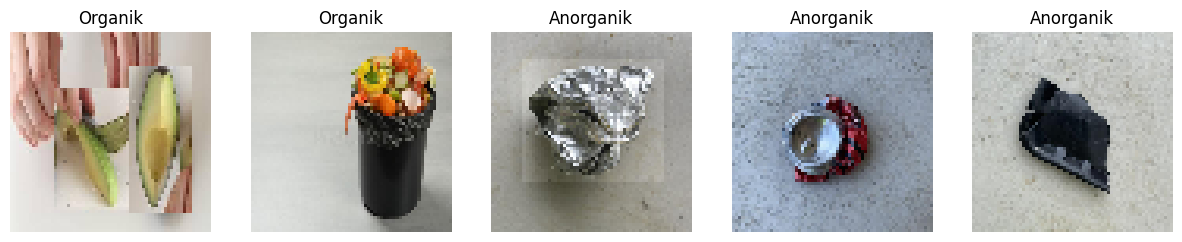

In [13]:
# Visualisasi contoh gambar
def show_sample_images(X, y, num_samples=5):
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        img = X[i].reshape(64, 64, 3)  # Reshape ke bentuk gambar 64x64 RGB
        plt.imshow(img)
        plt.title('Anorganik' if y[i] == 0 else 'Organik')
        plt.axis('off')
    plt.show()

# Tampilkan 5 sampel dari data train
show_sample_images(X_train, y_train)

# Pelatihan model dummy

In [14]:
# Inisialisasi model SVM
model = SVC(kernel='linear', random_state=42)

# Latih model
subset_size = 5000  # 5000 sampel untuk dummy awal
X_train_subset = X_train[:subset_size]
y_train_subset = y_train[:subset_size]

model.fit(X_train_subset, y_train_subset)

# Prediksi pada data test
y_pred = model.predict(X_test)

# Evaluasi model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Anorganik', 'Organik']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Classification Report:
              precision    recall  f1-score   support

   Anorganik       0.80      0.86      0.83      2673
     Organik       0.72      0.62      0.67      1489

    accuracy                           0.78      4162
   macro avg       0.76      0.74      0.75      4162
weighted avg       0.77      0.78      0.77      4162

Confusion Matrix:
[[2304  369]
 [ 563  926]]


# Testing/Inferensi sederhana

Saving 2.jpeg to 2.jpeg
Prediksi untuk 2.jpeg: Organik


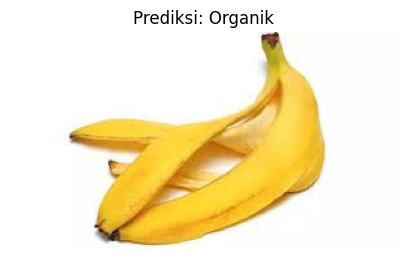

Saving 3.jpeg to 3.jpeg
Prediksi untuk 3.jpeg: Organik


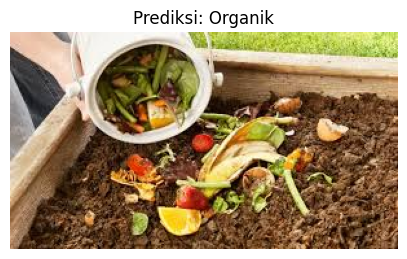

Saving 4.jpeg to 4.jpeg
Prediksi untuk 4.jpeg: Organik


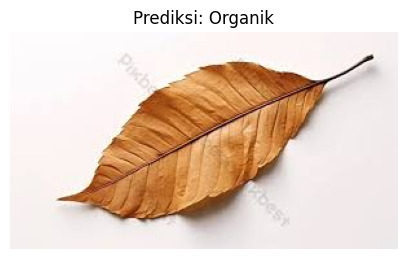

In [18]:
for _ in range(3):  # (3) Bisa sesuai kebutuhan
    uploaded = files.upload()
    uploaded_image_file = list(uploaded.keys())[0]
    test_image_path = uploaded_image_file

    result = predict_image(test_image_path, model)
    print(f"Prediksi untuk {uploaded_image_file}: {result}")

    img = cv2.imread(test_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"Prediksi: {result}")
    plt.axis('off')
    plt.show()

# Identifikasi sampah campuran dengan persentase & penandaan

## Preprocessing

In [16]:
# Fungsi preprocessing
def preprocess_image(image_path, target_size=(64, 64)):
    img = cv2.imread(image_path)
    if img is None:
        return None
    img = cv2.resize(img, target_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.flatten()
    return img

# Fungsi untuk memprediksi gambar utuh
def predict_image(image_path, model, target_size=(64, 64)):
    img = preprocess_image(image_path, target_size)
    if img is None:
        return "Error: Gambar tidak dapat dibaca"
    img = img.reshape(1, -1)
    prediction = model.predict(img)
    return 'Anorganik' if prediction[0] == 0 else 'Organik'

# Fungsi baru untuk identifikasi sampah campuran
def predict_mixed_waste(image_path, model, grid_size=(2, 2)):
    # Baca gambar asli
    original_img = cv2.imread(image_path)
    if original_img is None:
        return "Error: Gambar tidak dapat dibaca", None, None

    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    height, width, _ = original_img.shape

    # Ukuran setiap grid
    grid_h, grid_w = height // grid_size[0], width // grid_size[1]

    predictions = []
    boxes = []  # Untuk menyimpan koordinat grid dan label

    # Potong gambar menjadi grid
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            # Koordinat grid
            y_start = i * grid_h
            y_end = (i + 1) * grid_h
            x_start = j * grid_w
            x_end = (j + 1) * grid_w

            # Potong bagian gambar
            grid_img = original_img[y_start:y_end, x_start:x_end]
            cv2.imwrite('temp_grid.jpg', cv2.cvtColor(grid_img, cv2.COLOR_RGB2BGR))

            # Prediksi untuk setiap grid
            grid_data = preprocess_image('temp_grid.jpg')
            if grid_data is not None:
                grid_data = grid_data.reshape(1, -1)
                pred = model.predict(grid_data)[0]
                predictions.append(pred)
                boxes.append((x_start, y_start, x_end, y_end, pred))

    # Hitung persentase
    total_grids = len(predictions)
    if total_grids == 0:
        return "Error: Tidak ada prediksi", None, None

    organik_count = predictions.count(1)
    anorganik_count = predictions.count(0)
    organik_percent = (organik_count / total_grids) * 100
    anorganik_percent = (anorganik_count / total_grids) * 100

    # Gambar kotak penanda
    marked_img = original_img.copy()
    for box in boxes:
        x_start, y_start, x_end, y_end, pred = box
        color = (0, 255, 0) if pred == 1 else (255, 0, 0)  # Hijau untuk organik, merah untuk anorganik
        cv2.rectangle(marked_img, (x_start, y_start), (x_end, y_end), color, 2)
        label = "Organik" if pred == 1 else "Anorganik"
        cv2.putText(marked_img, label, (x_start, y_start-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return f"Organik: {organik_percent:.2f}%, Anorganik: {anorganik_percent:.2f}%", predictions, marked_img

# Testing lanjutan

Unggah gambar sampah campuran:


Saving 5.jpeg to 5.jpeg
Hasil prediksi untuk 5.jpeg: Organik: 25.00%, Anorganik: 75.00%
Prediksi per grid: ['Organik', 'Anorganik', 'Anorganik', 'Anorganik']


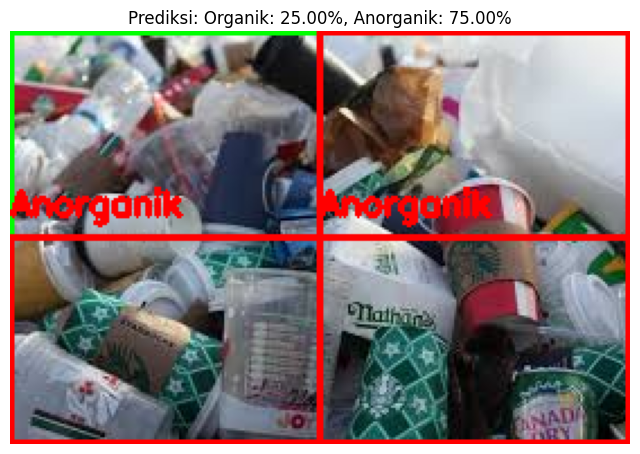

In [17]:
for _ in range(1):
    print("Unggah gambar sampah campuran:")
    uploaded = files.upload()
    uploaded_image_file = list(uploaded.keys())[0]
    test_image_path = uploaded_image_file

    result, predictions, marked_img = predict_mixed_waste(test_image_path, model)
    print(f"Hasil prediksi untuk {uploaded_image_file}: {result}")
    print(f"Prediksi per grid: {['Anorganik' if p == 0 else 'Organik' for p in predictions]}")

    if marked_img is not None:
        plt.figure(figsize=(8, 8))
        plt.imshow(marked_img)
        plt.title(f"Prediksi: {result}")
        plt.axis('off')
        plt.show()

# Save dalam format pickle

In [19]:
# Simpan model ke file pickle
with open('trash_classifier_model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model telah disimpan sebagai 'trash_classifier_model.pkl'")

Model telah disimpan sebagai 'trash_classifier_model.pkl'


In [20]:
# Unduh file ke lokal (opsional)
from google.colab import files
files.download('trash_classifier_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>